# (Practice) Shap with the Titanic
- For this assignment you will be fitting a machine learning model to predict survivors of the titanic.
    - This assignment is focused on working with Shap, so we have provided the code up through the modeling process.
- After fitting the model, use Shap to create:
    - A summary plot for passengers that Survived.
    - In a markdown cell below, interpret the top 5 most important features (according to shap).
        - Do these results make sense based on what you know about the Titanic?

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

In [2]:
fname = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR9Yhcch85ziIad4CyZQqLtYijHgsuENLfyC0YAXlajVbSC7U7s3CUUsfG-OYIKOjTI9DdKZH1xMs3a/pub?output=csv'
df = pd.read_csv(fname,index_col = 0)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# ### Train Test Split
## Make x and y variables
drop_feats = ["Name","Ticket","Cabin"]
y = df['Survived'].copy()
X = df.drop(columns=['Survived',*drop_feats]).copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED)
# ### Preprocessing + ColumnTransformer
## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include = 'object')
num_sel = make_column_selector(dtype_include = 'number')
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy = 'constant',
                                       fill_value = 'MISSING'),
                         OneHotEncoder(drop = 'if_binary', sparse = False))
num_pipe = make_pipeline(SimpleImputer(strategy = 'mean'))
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_MISSING,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
355,3.0,30.314472,0.0,0.0,7.225,1.0,1.0,0.0,0.0,0.0
519,2.0,36.000000,1.0,0.0,26.000,0.0,0.0,0.0,0.0,1.0
814,3.0,6.000000,4.0,2.0,31.275,0.0,0.0,0.0,0.0,1.0


In [4]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_df, y_train)

RandomForestClassifier()

In [16]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            normalize = 'true', cmap = 'Blues', 
                            figsize = (10, 5)):
    header = "\tCLASSIFICATION REPORT"
    dashes = '--'*40
    print(f"{dashes}\n{header}\n{dashes}")

    # training data

    print('[i] Training Data:')
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)
    fig,ax = plt.subplots(figsize = figsize, ncols = 2)
    metrics.ConfusionMatrixDisplay.from_estimator(model, X_train, y_train,
                                                  normalize = normalize,
                                                  cmap = cmap, ax = ax[0])
    metrics.RocCurveDisplay.from_estimator(model, X_train, y_train, ax = ax[1])
    ax[1].plot([0, 1], [0, 1], ls = ':')
    ax[1].grid() 
    
    fig.tight_layout()
    plt.show()
     
    print(dashes)

    # test data

    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)
    fig,ax = plt.subplots(figsize = figsize, ncols = 2)
    metrics.ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                                  normalize = normalize, 
                                                  cmap = cmap, ax = ax[0])
    metrics.RocCurveDisplay.from_estimator(model, X_test, y_test, ax = ax[1])
    ax[1].plot([0, 1], [0, 1], ls = ':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       419
           1       0.98      0.97      0.98       249

    accuracy                           0.98       668
   macro avg       0.98      0.98      0.98       668
weighted avg       0.98      0.98      0.98       668



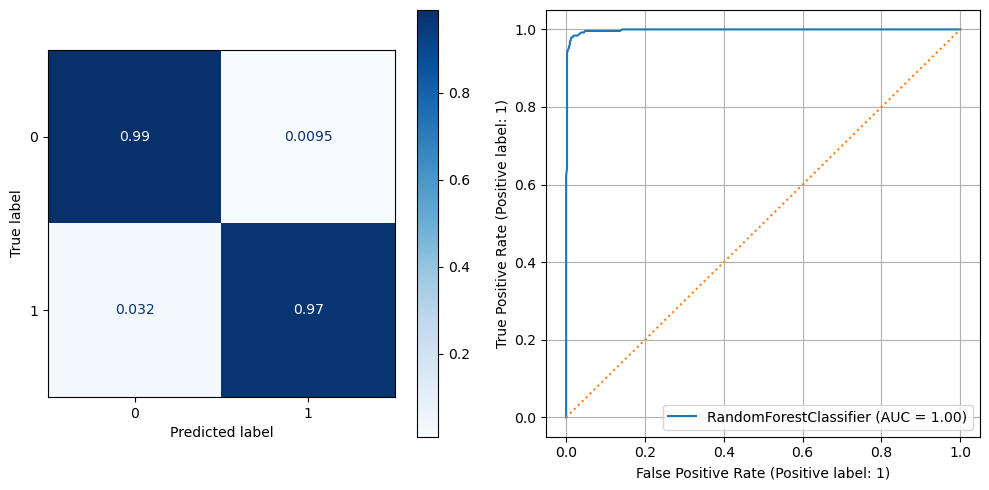

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       130
           1       0.81      0.83      0.82        93

    accuracy                           0.85       223
   macro avg       0.84      0.84      0.84       223
weighted avg       0.85      0.85      0.85       223



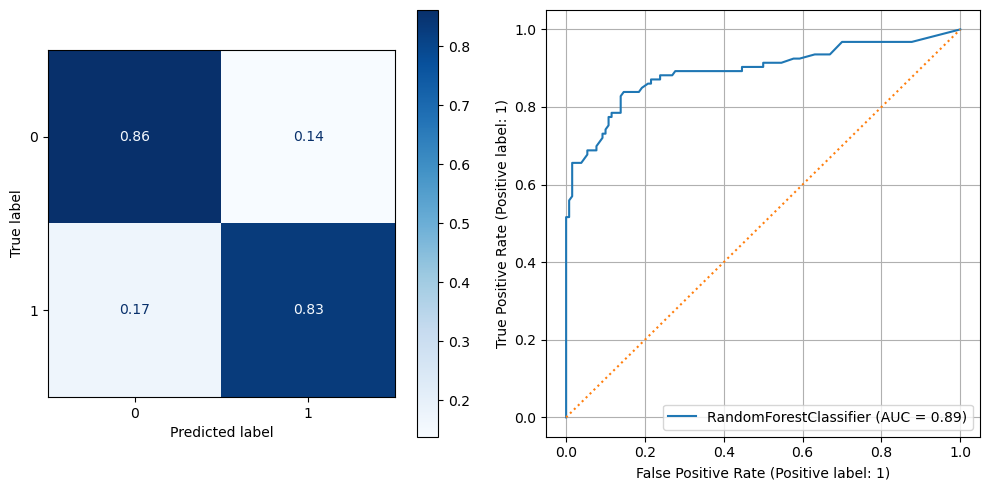

In [17]:
evaluate_classification(rf_clf, X_train_df, y_train, X_test_df, y_test)

# Shap

In [5]:
# Import shap and initialize javascript:
import shap
shap.initjs()

In [6]:
#check length of out X data
len(X_train_df)

668

In [7]:
# reduce the lengjt to 500 observations
X_shap = shap.sample(X_train_df, nsamples = 500, random_state = 321)
X_shap.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_MISSING,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
811,3.0,26.0,0.0,0.0,7.8875,1.0,0.0,0.0,0.0,1.0
736,3.0,28.5,0.0,0.0,16.1000,1.0,0.0,0.0,0.0,1.0
386,2.0,18.0,0.0,0.0,73.5000,1.0,0.0,0.0,0.0,1.0
290,3.0,22.0,0.0,0.0,7.7500,0.0,0.0,0.0,1.0,0.0
707,2.0,45.0,0.0,0.0,13.5000,0.0,0.0,0.0,0.0,1.0


In [8]:
# get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap 

PassengerId
811    0
736    0
386    0
290    1
707    1
      ..
133    0
616    1
265    0
710    1
616    1
Name: Survived, Length: 500, dtype: int64

In [9]:
# Create a SHAP explainer using your fit model
explainer = shap.Explainer(rf_clf)
explainer

In [10]:
# Get SHAP values from explainer for your training data
shap_values = explainer(X_shap, y_shap)
type(shap_values)

shap._explanation.Explanation

In [11]:
# check dimention of our shap
shap_values.shape

(500, 10, 2)

In [18]:
# slicing for survived values (0 is dead, 1 is survived. Under our target)
shap_survived = shap_values[:, :, 1]
shap_survived.shape

(500, 10)

In [19]:
# view in dataframe
pd.DataFrame(shap_survived.values, columns = X_shap.columns)

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_MISSING,Embarked_Q,Embarked_S
0,-0.045220,0.021269,0.004702,-0.003341,-0.141929,-0.160772,-0.009718,-0.000012,-0.008925,-0.018045
1,-0.057410,-0.023499,0.007295,-0.005031,-0.042222,-0.184370,-0.015882,-0.000011,-0.004488,-0.016373
2,-0.070058,0.008629,-0.001290,-0.009811,0.005076,-0.228262,-0.025283,-0.000015,-0.000533,-0.020444
3,-0.063844,0.004795,0.014367,0.015217,0.012684,0.326203,-0.008738,-0.000009,-0.012098,0.002671
4,0.106056,-0.016690,0.050137,0.007178,0.028766,0.412772,0.000935,-0.000015,0.000190,-0.001319
...,...,...,...,...,...,...,...,...,...,...
495,-0.137023,-0.146094,-0.031048,-0.007693,-0.081731,0.231398,-0.000811,-0.000012,-0.007925,-0.001053
496,0.105541,0.001644,0.019129,0.020646,0.126662,0.355342,-0.011876,-0.000012,0.001386,-0.010454
497,-0.060572,0.033504,0.013935,0.026019,0.000703,0.378178,-0.009294,-0.000010,0.034844,0.069318
498,-0.005827,0.020802,0.065596,0.119797,0.087854,-0.060633,0.159620,-0.000010,0.017774,0.103037


## Summary Plot - Bar

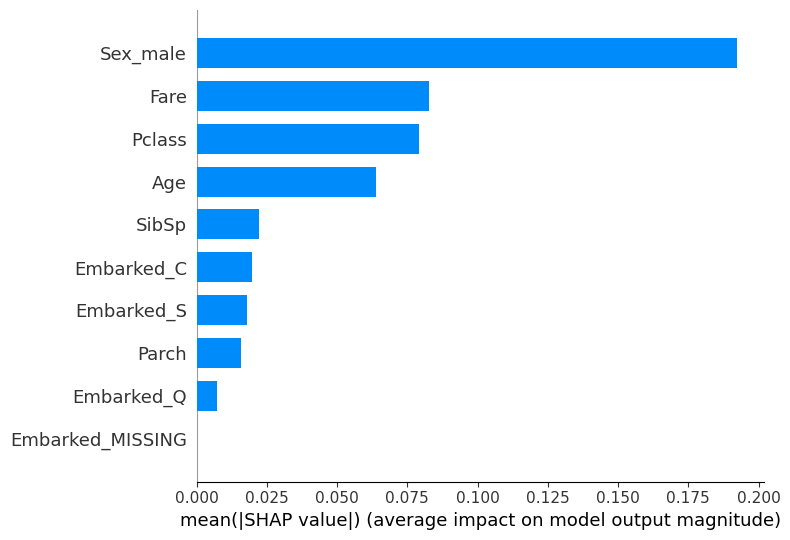

In [21]:
shap.summary_plot(shap_survived, features = X_shap, plot_type = 'bar')

- This uses the magnitude of average SHAP values to show which features had the biggest impact on the models prediction.
- Sex_male is the most important feature for predicting if the passenger has survived the sinking of the Titanic.

## Summary Plot - dot (default)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


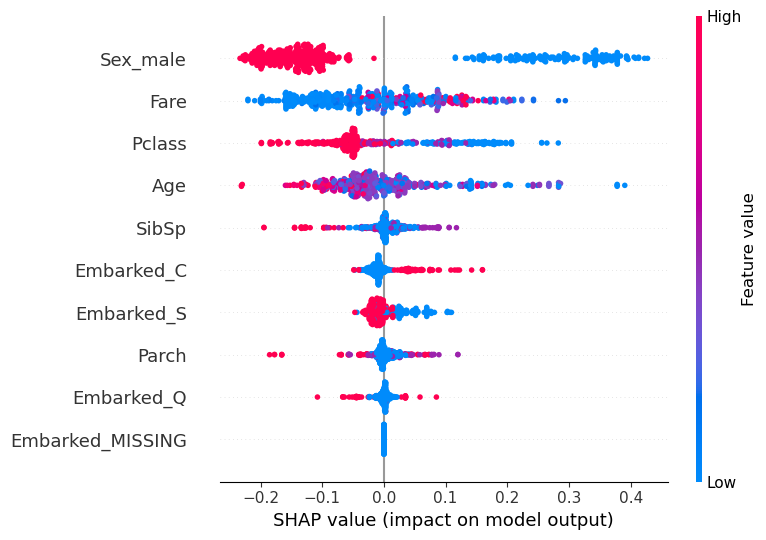

In [22]:
shap.summary_plot(shap_survived, X_shap)

- Each dot represents an observation/row.
- Male gender has the largest effect on the model's prediction. 
    - The Red values are on the left (negative), we can interpret that if the sample is male. The less likely will it predict that the passenger will survived. 
- Fare has the 2nd largest effect on the mode's prediction.
    - Red values are mostly on the right side (positive). The higher the Fare is, the more likely the passenger will survived.
- Pclass has the 3rd effect on models prediction.
- Age has the 4th effect on models prediction.
- SibSp has the 5th effect on models predition.